In [2]:
!unzip "/content/drive/MyDrive/Augmented.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Augmented/EC/EC_83_02.jpg  
  inflating: Augmented/EC/EC_83_03.jpg  
  inflating: Augmented/EC/EC_83_04.jpg  
  inflating: Augmented/EC/EC_83_05.jpg  
  inflating: Augmented/EC/EC_83_06.jpg  
  inflating: Augmented/EC/EC_83_07.jpg  
  inflating: Augmented/EC/EC_84_01.jpg  
  inflating: Augmented/EC/EC_84_02.jpg  
  inflating: Augmented/EC/EC_84_03.jpg  
  inflating: Augmented/EC/EC_84_04.jpg  
  inflating: Augmented/EC/EC_84_05.jpg  
  inflating: Augmented/EC/EC_84_06.jpg  
  inflating: Augmented/EC/EC_84_07.jpg  
  inflating: Augmented/EC/EC_85_01.jpg  
  inflating: Augmented/EC/EC_85_02.jpg  
  inflating: Augmented/EC/EC_85_03.jpg  
  inflating: Augmented/EC/EC_85_04.jpg  
  inflating: Augmented/EC/EC_85_05.jpg  
  inflating: Augmented/EC/EC_85_06.jpg  
  inflating: Augmented/EC/EC_85_07.jpg  
  inflating: Augmented/EC/EC_86_01.jpg  
  inflating: Augmented/EC/EC_86_02.jpg  
  inflating: Augmented/EC/EC_86_03.jpg  
  infl

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ============================================
# ResNet50 Skin Disease Pipeline (Ultra-Stable v3)
# ============================================

# --- Imports
import os, re, math, random, itertools
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120  # on-screen; saves use dpi=600

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, accuracy_score)
from sklearn.preprocessing import label_binarize

# ----------------------------
# GPU memory safety (Colab)
# ----------------------------
tf.keras.backend.clear_session()
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("Memory growth not set:", e)

# Mixed precision (cuts memory)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision enabled.")
except Exception as e:
    print("Mixed precision not available:", e)

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

DATA_DIR = Path("/content/Augmented")        # subfolders AD/CD/EC/SC/SD/TC
OUT_DIR  = Path("/content/skin_resnet50_outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)

CLASSES     = ["AD","CD","EC","SC","SD","TC"]
IMG_SIZE    = (192, 192)   # ↓ lower memory than 224
BATCH_SIZE  = 12           # ↓ lower memory than 16/32
WARMUP_EPOCHS   = 5
FINETUNE_EPOCHS = 12       # we’ll rely on EarlyStopping anyway

CKPT_WEIGHTS = OUT_DIR / "resnet50_skin_model.weights.h5"
FINAL_MODEL  = OUT_DIR / "resnet50_skin_model.keras"

# ----------------------------
# Discover data (supports subfolders or filenames)
# ----------------------------
VALID_EXT = {".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff"}
files = [p for p in DATA_DIR.rglob("*") if p.is_file() and p.suffix.lower() in VALID_EXT]
if len(files) == 0:
    raise FileNotFoundError(f"No images found under {DATA_DIR} (including subfolders).")

def infer_label(path: Path):
    parent = path.parent.name.upper()
    if parent in CLASSES:
        return parent
    base = path.name.lower()
    for c in CLASSES:
        if re.search(rf'(?<![A-Za-z0-9]){re.escape(c.lower())}(?![A-Za-z0-9])', base):
            return c
    return None

records = []
for p in files:
    lab = infer_label(p)
    if lab is not None:
        records.append((str(p), lab))

df = pd.DataFrame(records, columns=["path","label"])
if df.empty:
    raise RuntimeError("Found images, but none matched labels via parent folder or filename.")

print("Total images:", len(df))
print("Class counts (all):", Counter(df['label']))

# ----------------------------
# Label index mappings
# ----------------------------
class2idx = {c: i for i, c in enumerate(CLASSES)}
idx2class = {i: c for c, i in class2idx.items()}

# ----------------------------
# Stratified split (70/15/15)
# ----------------------------
X = df['path'].values
y = df['label'].values

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_val_idx, test_idx = next(sss1.split(X, y))
X_train_val, X_test = X[train_val_idx], X[test_idx]
y_train_val, y_test = y[train_val_idx], y[test_idx]

val_ratio_of_remaining = 0.15 / 0.85
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio_of_remaining, random_state=SEED)
train_idx, val_idx = next(sss2.split(X_train_val, y_train_val))

X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

print("Split sizes:", len(X_train), len(X_val), len(X_test))
print("Train dist:", Counter(y_train))
print("Val   dist:", Counter(y_val))
print("Test  dist:", Counter(y_test))

# ----------------------------
# tf.data pipelines (lighter aug)
# ----------------------------
AUTOTUNE = tf.data.AUTOTUNE

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def make_ds(paths, labels, shuffle=False):
    paths  = tf.convert_to_tensor(paths, dtype=tf.string)
    labels = tf.convert_to_tensor([class2idx[l] for l in labels], dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, l: (decode_img(p), l),
                num_parallel_calls=AUTOTUNE, deterministic=False)
    if shuffle:
        ds = ds.shuffle(buffer_size=min(2048, len(paths)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Simpler augmentation to avoid spikes
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(0.10),
], name="augmentation")

train_raw = make_ds(X_train, y_train, shuffle=True)
val_ds    = make_ds(X_val,   y_val,   shuffle=False)
test_ds   = make_ds(X_test,  y_test,  shuffle=False)

train_ds = train_raw.map(lambda x, y: (data_augmentation(x, training=True), y),
                         num_parallel_calls=AUTOTUNE)

# ----------------------------
# Class weights (handle imbalance)
# ----------------------------
train_counts = Counter(y_train)
total = sum(train_counts.values())
class_weight = {class2idx[c]: total/(len(CLASSES)*train_counts[c]) for c in CLASSES}
print("Class weights:", class_weight)

# ----------------------------
# Build model (ResNet50)
# ----------------------------
base = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3)
)
base.trainable = False  # warmup

inputs = keras.Input(shape=(*IMG_SIZE,3))
x = keras.applications.resnet.preprocess_input(inputs * 255.0)  # expects 0-255
x = base(x, training=False)   # keep backbone in inference mode (BN stable)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.30)(x)
outputs = layers.Dense(len(CLASSES), activation="softmax", dtype="float32")(x)  # stable dtype under MP
model = keras.Model(inputs, outputs)

opt_warm = keras.optimizers.Adam(1e-3)
opt_ft   = keras.optimizers.Adam(1e-5)

early = keras.callbacks.EarlyStopping(
    patience=3, monitor="val_accuracy", mode="max", restore_best_weights=True
)
reduce = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
)
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=str(CKPT_WEIGHTS),
    monitor="val_accuracy", mode="max",
    save_best_only=True, save_weights_only=True
)
csvlog = keras.callbacks.CSVLogger(str(OUT_DIR / "training_log.csv"))

# ----------------------------
# Warmup (frozen base)
# ----------------------------
model.compile(
    optimizer=opt_warm,
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    steps_per_execution=64
)
print("\n--- Warmup training ---")
hist1 = model.fit(
    train_ds, validation_data=val_ds, epochs=WARMUP_EPOCHS,
    class_weight=class_weight, callbacks=[ckpt, early, reduce, csvlog], verbose=2
)

# ----------------------------
# Fine-tune (unfreeze last ~10 layers; keep BN frozen)
# ----------------------------
base.trainable = True
for layer in base.layers[:-10]:
    layer.trainable = False
for layer in base.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model.compile(
    optimizer=opt_ft,
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    steps_per_execution=64
)
print("\n--- Fine-tuning ---")
hist2 = model.fit(
    train_ds, validation_data=val_ds, epochs=FINETUNE_EPOCHS,
    class_weight=class_weight, callbacks=[ckpt, early, reduce, csvlog], verbose=2
)

# Combine histories
history = {}
for k in set(hist1.history) | set(hist2.history):
    history[k] = hist1.history.get(k, []) + hist2.history.get(k, [])


Mixed precision enabled.
Total images: 11970
Class counts (all): Counter({'CD': 3339, 'EC': 3262, 'SC': 2401, 'TC': 1925, 'SD': 553, 'AD': 490})
Split sizes: 8378 1796 1796
Train dist: Counter({'CD': 2337, 'EC': 2283, 'SC': 1681, 'TC': 1347, 'SD': 387, 'AD': 343})
Val   dist: Counter({'CD': 501, 'EC': 490, 'SC': 360, 'TC': 289, 'SD': 83, 'AD': 73})
Test  dist: Counter({'CD': 501, 'EC': 489, 'SC': 360, 'TC': 289, 'SD': 83, 'AD': 74})
Class weights: {0: 4.070942662779397, 1: 0.5974896591071174, 2: 0.6116221346181925, 3: 0.8306563553440413, 4: 3.608096468561585, 5: 1.0366245978718138}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Warmup training ---
Epoch 1/5
699/699 - 94s - 134ms/step - accuracy: 0.4933 - loss: 1.3742 - val_accuracy: 0.5963 - val_loss: 1.0336 - learning_rate: 1.0000e-03
Epoch 2/5
699/699 - 108s - 154ms/step - accuracy: 0.6223 - loss: 0.9130 - val_accuracy: 0.6932 - val_loss: 0.8322 - learning_rate: 1.0000e-03
Epoch 3/5
699/699 - 50s - 72ms/step - accuracy: 0.66

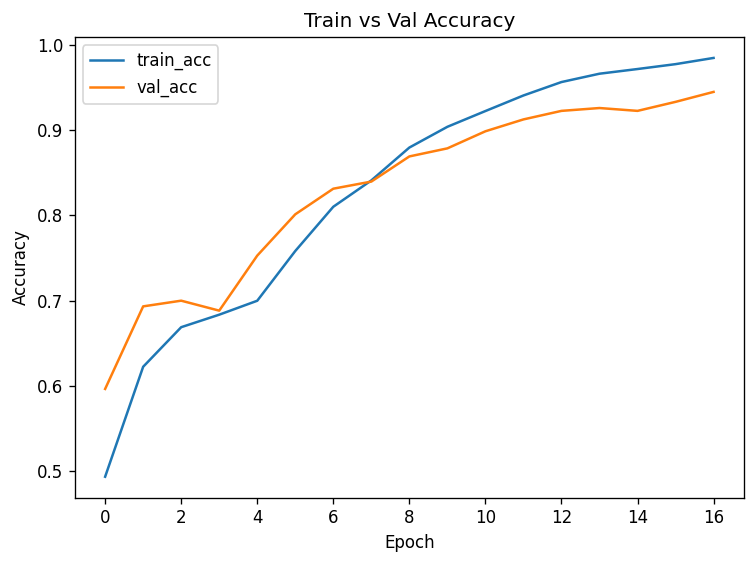

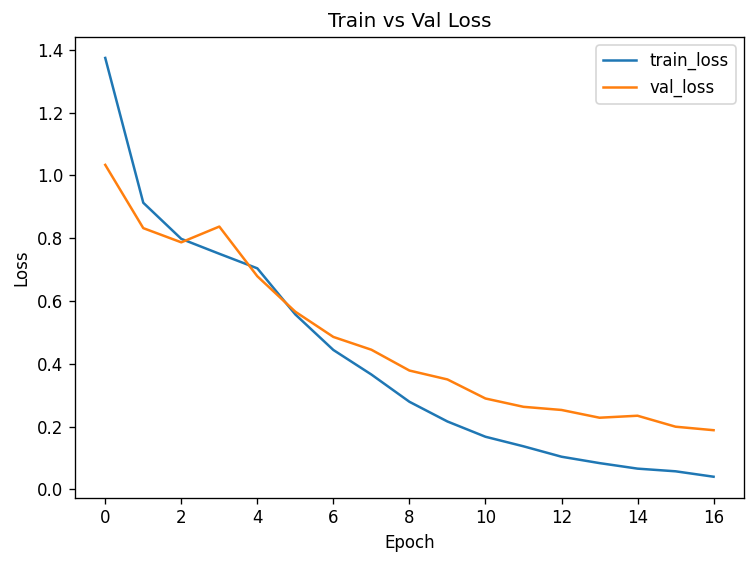


Final Train Accuracy: 0.9847
Final Val   Accuracy: 0.9449


In [4]:
# ----------------------------
# Save curves @ 600 dpi
# ----------------------------
def plot_save_history(hist, out_prefix):
    if "accuracy" in hist:
        plt.figure()
        plt.plot(hist["accuracy"], label="train_acc")
        plt.plot(hist["val_accuracy"], label="val_acc")
        plt.xlabel("Epoch");
        plt.ylabel("Accuracy");
        plt.legend();
        plt.title("Train vs Val Accuracy")
        plt.tight_layout();
        plt.savefig(OUT_DIR / f"{out_prefix}_accuracy_600dpi.png", dpi=600);
        plt.show()
    if "loss" in hist:
        plt.figure()
        plt.plot(hist["loss"], label="train_loss")
        plt.plot(hist["val_loss"], label="val_loss")
        plt.xlabel("Epoch");
        plt.ylabel("Loss");
        plt.legend();
        plt.title("Train vs Val Loss")
        plt.tight_layout();
        plt.savefig(OUT_DIR / f"{out_prefix}_loss_600dpi.png", dpi=600);
        plt.show()

plot_save_history(history, "resnet50")

final_train_acc = history.get("accuracy", [None])[-1]
final_val_acc   = history.get("val_accuracy", [None])[-1]
print(f"\nFinal Train Accuracy: {final_train_acc:.4f}" if final_train_acc is not None else "Final Train Accuracy: N/A")
print(f"Final Val   Accuracy: {final_val_acc:.4f}"   if final_val_acc   is not None else "Final Val Accuracy: N/A")

In [5]:
# ----------------------------
# Load best weights, save full model
# ----------------------------
model.load_weights(CKPT_WEIGHTS)
model.save(FINAL_MODEL)

In [6]:
# ----------------------------
# Evaluate on test
# ----------------------------
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.array([class2idx[l] for l in y_test])

test_acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification report
report = classification_report(y_true, y_pred, target_names=CLASSES, digits=4)
print("\nClassification Report:\n", report)
with open(OUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)



Test Accuracy: 0.9321

Classification Report:
               precision    recall  f1-score   support

          AD     0.8750    0.8514    0.8630        74
          CD     0.9567    0.9261    0.9412       501
          EC     0.9205    0.9468    0.9335       489
          SC     0.9632    0.9444    0.9537       360
          SD     0.9024    0.8916    0.8970        83
          TC     0.8970    0.9343    0.9153       289

    accuracy                         0.9321      1796
   macro avg     0.9191    0.9158    0.9173      1796
weighted avg     0.9327    0.9321    0.9322      1796



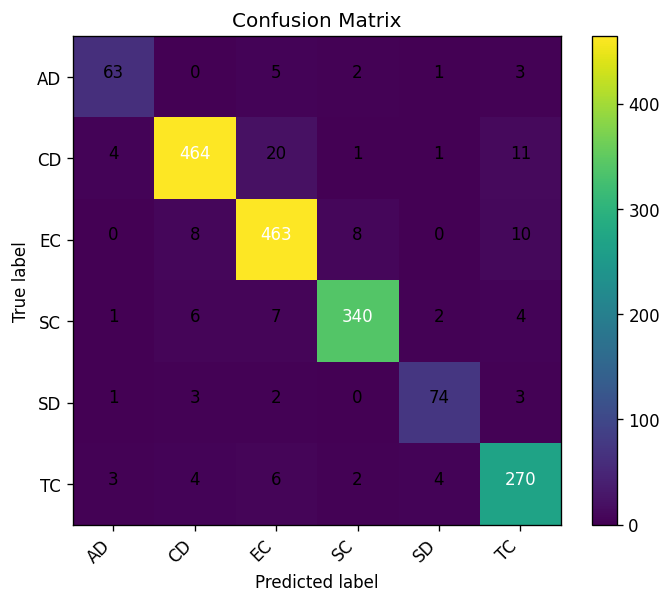

In [7]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(CLASSES))
plt.xticks(ticks, CLASSES, rotation=45, ha='right'); plt.yticks(ticks, CLASSES)
thr = cm.max()/2 if cm.max() > 0 else 0.5
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", color="white" if cm[i, j] > thr else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label')
plt.tight_layout(); plt.savefig(OUT_DIR / "confusion_matrix_600dpi.png", dpi=600);
plt.show()

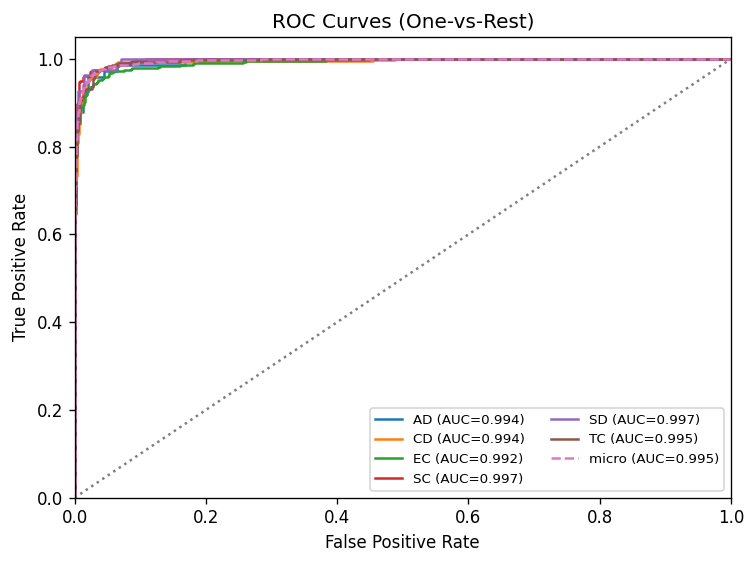

In [9]:
#ROC curves (one-vs-rest + micro)
y_true_bin = label_binarize(y_true, classes=list(range(len(CLASSES))))
fpr = {}; tpr = {}; roc_auc = {}
for i in range(len(CLASSES)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
for i, c in enumerate(CLASSES):
    plt.plot(fpr[i], tpr[i], label=f"{c} (AUC={roc_auc[i]:.3f})")
plt.plot(fpr["micro"], tpr["micro"], linestyle="--", label=f"micro (AUC={roc_auc['micro']:.3f})")
plt.plot([0,1],[0,1], linestyle=":")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right", ncol=2, fontsize=8)
plt.tight_layout();
plt.savefig(OUT_DIR / "roc_curves_600dpi.png", dpi=600);
plt.show()

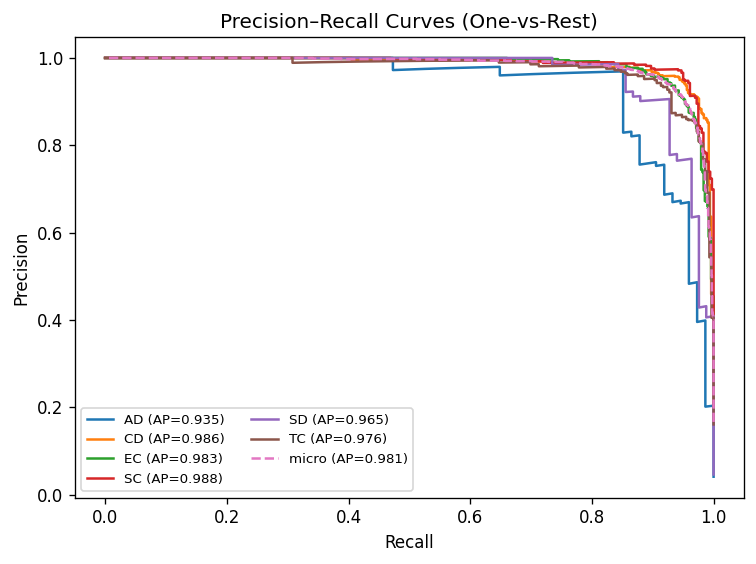

In [11]:
# ====== Precision–Recall (PR) Curves ======
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
# Binarize ground-truth for one-vs-rest PR computation
y_true_bin = label_binarize(y_true, classes=list(range(len(CLASSES))))

# Per-class PR curves and Average Precision (AP)
precision = {}
recall = {}
ap = {}
for i, c in enumerate(CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Micro-average PR (aggregate all classes)
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_prob.ravel())
ap["micro"] = average_precision_score(y_true_bin, y_prob, average="micro")

# (Optional) Macro AP as the unweighted mean of per-class APs
ap["macro"] = float(np.mean([ap[i] for i in range(len(CLASSES))]))

# Plot PR curves (per-class + micro)
plt.figure()
for i, c in enumerate(CLASSES):
    plt.plot(recall[i], precision[i], label=f"{c} (AP={ap[i]:.3f})")
plt.plot(recall["micro"], precision["micro"], linestyle="--",
         label=f"micro (AP={ap['micro']:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (One-vs-Rest)")
plt.legend(loc="lower left", ncol=2, fontsize=8)
plt.tight_layout()
plt.savefig(OUT_DIR / "pr_curves_600dpi.png", dpi=600)
plt.show()


In [13]:
# ====== Prediction vs Actual: Image Grid (600 dpi) ======
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# If you don't already have y_prob from earlier, uncomment:
# y_prob = model.predict(test_ds, verbose=0)

# Align with your requested variable names
y_score   = y_prob                      # shape: [N, num_classes]
y_pred_np = np.argmax(y_score, axis=1)

# y_true (ints) may already exist; if not, build from y_test strings
try:
    y_true_np = np.array(y_true)
except NameError:
    y_true_np = np.array([class2idx[l] for l in y_test])

# Class labels: use your existing CLASSES list (no LabelEncoder needed)
class_labels = list(CLASSES)

# Test file paths
test_paths = list(X_test)  # ensure list of strings
filenames = [os.path.relpath(p, str(DATA_DIR)) for p in test_paths]

# Plotting sample test images with true/predicted labels
num_images = 10  # adjust as you like
cols = 5
rows = num_images // cols + int(num_images % cols > 0)

os.makedirs("evaluation_plots", exist_ok=True)
plt.figure(figsize=(20, rows * 4), dpi=600)

for i in range(min(num_images, len(test_paths))):
    img_path = test_paths[i]
    # Load & resize for display (IMG_SIZE is a tuple, e.g., (192, 192) or (224, 224))
    img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
    img_array = np.array(img) / 255.0

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_array)
    plt.axis('off')

    true_label = class_labels[y_true_np[i]]
    pred_label = class_labels[y_pred_np[i]]
    confidence = float(np.max(y_score[i]) * 100.0)

    title_color = 'green' if true_label == pred_label else 'red'
    plt.title(
        f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%",
        color=title_color,
        fontsize=10,
    )

plt.tight_layout()
plt.savefig("evaluation_plots/prediction_vs_actual.png", dpi=600, bbox_inches='tight')
plt.show()

